In [1]:
!pip install isodate


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Part B: How do these airlines decide the fares?

## (i) Outlier detection and handling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import isodate

In [3]:
data_path = "../Dataset/split_01.csv"
df = pd.read_csv(data_path)

print(df.head())


                              legId  searchDate  flightDate startingAirport  \
0  cc7ca757dcd0ff76b2f0b4eb37419886  2022-04-16  2022-04-17             ATL   
1  398e2cd3e08b555a1f8c2113824474ca  2022-04-16  2022-04-17             ATL   
2  12ace2050ae312b0223484a949eaf227  2022-04-16  2022-04-17             ATL   
3  1122006b99c9a15118b2e469815555db  2022-04-16  2022-04-17             ATL   
4  97a100c46442e1d44b9a347e07124f01  2022-04-16  2022-04-17             ATL   

  destinationAirport fareBasisCode travelDuration  elapsedDays  \
0                CLT      QAA0JHES        PT5H52M            0   
1                DTW      L0AIZNN1        PT3H46M            0   
2                DTW      KA0NX0MC        PT8H45M            1   
3                DTW      QA0NA0MC         PT8H9M            1   
4                DTW      MA0QA0MQ        PT5H12M            0   

   isBasicEconomy  isRefundable  ...  segmentsArrivalTimeEpochSeconds  \
0           False         False  ...           16502404

In [4]:
print("Length before dropping rows:", len(df))
df.dropna(inplace=True)
print("Length after dropping rows:", len(df))


Length before dropping rows: 4106023
Length after dropping rows: 3736879


In [5]:
# Filter only non-stop flights
non_stop_df = df[df['isNonStop'] == True]

print("Non-stop flights shape:", non_stop_df.shape)
print(non_stop_df[['baseFare', 'totalFare']].describe())


Non-stop flights shape: (996418, 27)
            baseFare      totalFare
count  996418.000000  996418.000000
mean      223.411594     254.664695
std       153.567157     165.074829
min         8.720000      23.970000
25%       127.440000     151.600000
50%       189.770000     218.600000
75%       280.000000     315.600000
max      4566.510000    4923.600000


### Outlier Detection #1

Let us begin by detecting outliers using the Interquartile Range (IQR) method on the baseFare column.
We will define outliers as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

In [6]:
Q1 = non_stop_df['baseFare'].quantile(0.25)
Q3 = non_stop_df['baseFare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Outlier lower bound: {lower_bound}")
print(f"Outlier upper bound: {upper_bound}")


Q1: 127.44, Q3: 280.0, IQR: 152.56
Outlier lower bound: -101.4
Outlier upper bound: 508.84000000000003


In [7]:
outliers = non_stop_df[(non_stop_df['baseFare'] < lower_bound) | (non_stop_df['baseFare'] > upper_bound)]
print(f"Number of outliers in baseFare: {len(outliers)}")

print(outliers[['baseFare', 'totalFare']].head())


Number of outliers in baseFare: 37001
     baseFare  totalFare
9      543.26     598.61
19    1585.12    1718.60
20    1500.47    1627.61
88     580.47     638.61
204   1858.60    2012.60


In [8]:
cleaned_df = non_stop_df[(non_stop_df['baseFare'] >= lower_bound) & (non_stop_df['baseFare'] <= upper_bound)]

print(f"Length before removing outliers: {len(non_stop_df)}")
print(f"Length after removing outliers: {len(cleaned_df)}")


Length before removing outliers: 996418
Length after removing outliers: 959417


### Outlier Detection #2

Now, let us apply the Z-score method to detect outliers in the baseFare column.
We will consider values with absolute Z-score greater than 3 as outliers (i.e., more than 3 standard deviations away from the mean).

In [9]:
mean_fare = non_stop_df['baseFare'].mean()
std_fare = non_stop_df['baseFare'].std()

non_stop_df.loc[:, 'zscore'] = (non_stop_df['baseFare'] - mean_fare) / std_fare

z_outliers = non_stop_df[non_stop_df['zscore'].abs() > 3]
print(f"Number of Z-score outliers: {len(z_outliers)}")

print(z_outliers[['baseFare', 'zscore']].head())


Number of Z-score outliers: 12585
     baseFare     zscore
19    1585.12   8.867185
20    1500.47   8.315960
204   1858.60  10.648035
208    757.21   3.475993
366    747.91   3.415433


C:\Users\kmakadia\AppData\Local\Temp\ipykernel_18188\664749125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_stop_df.loc[:, 'zscore'] = (non_stop_df['baseFare'] - mean_fare) / std_fare


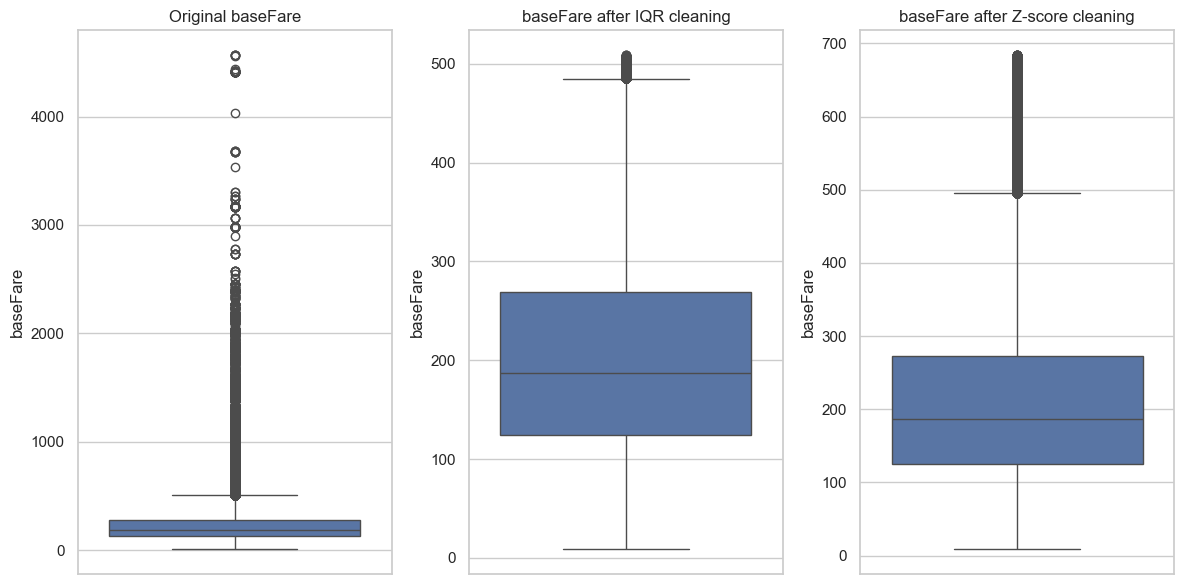

In [10]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=non_stop_df['baseFare'])
plt.title('Original baseFare')

plt.subplot(1, 3, 2)
sns.boxplot(y=cleaned_df['baseFare'])
plt.title('baseFare after IQR cleaning')

z_cleaned_df = non_stop_df[non_stop_df['zscore'].abs() <= 3]
plt.subplot(1, 3, 3)
sns.boxplot(y=z_cleaned_df['baseFare'])
plt.title('baseFare after Z-score cleaning')

plt.tight_layout()
plt.show()


### Outlier Handling: Final Decision

We compared the distribution of `baseFare` before and after outlier removal using both the **IQR** and **Z-score** methods.

- The **original distribution** showed a long tail with extreme outliers, which heavily skewed the data.
- The **IQR method** successfully removed most extreme values beyond the upper whisker, resulting in a compact and more symmetric distribution.
- The **Z-score method**, although statistically principled, retained a wider range of upper values — including some fares above $600 — which could still introduce skewness in downstream regression models.

Given our goal of understanding the general pricing trend without distortion from extreme values, we find the **IQR method** to be more effective for this dataset.

🔎 **Hence, we will proceed with the dataset cleaned using the IQR method (`cleaned_df`)** in the subsequent parts of the project.


## (ii) Relationship between fare and distance.

We will begin by plotting all individual baseFare values against their corresponding segmentsDistance. Since there are many fares for the same distance, the trend may not be clearly visible, but it will help us understand the spread.

C:\Users\kmakadia\AppData\Local\Temp\ipykernel_18188\1328966838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['segmentsDistance'] = pd.to_numeric(cleaned_df['segmentsDistance'], errors='coerce')


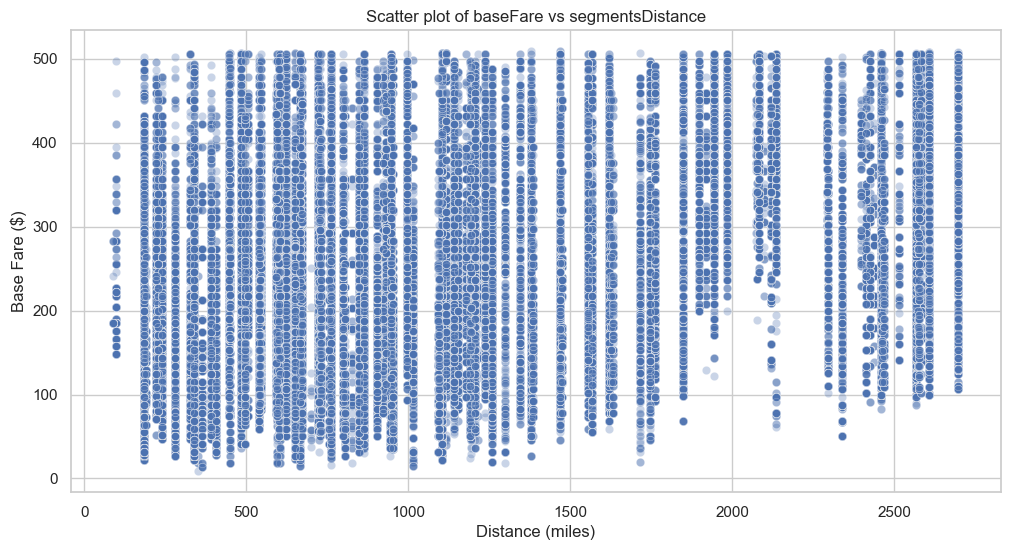

In [11]:
cleaned_df['segmentsDistance'] = pd.to_numeric(cleaned_df['segmentsDistance'], errors='coerce')

# Scatter plot of baseFare vs segmentsDistance
plt.figure(figsize=(12, 6))
sns.scatterplot(data=cleaned_df, x='segmentsDistance', y='baseFare', alpha=0.3)

plt.title("Scatter plot of baseFare vs segmentsDistance")
plt.xlabel("Distance (miles)")
plt.ylabel("Base Fare ($)")
plt.grid(True)
plt.show()

We will now group the dataset by segmentsDistance, calculate the average baseFare for each group, and plot the resulting trend

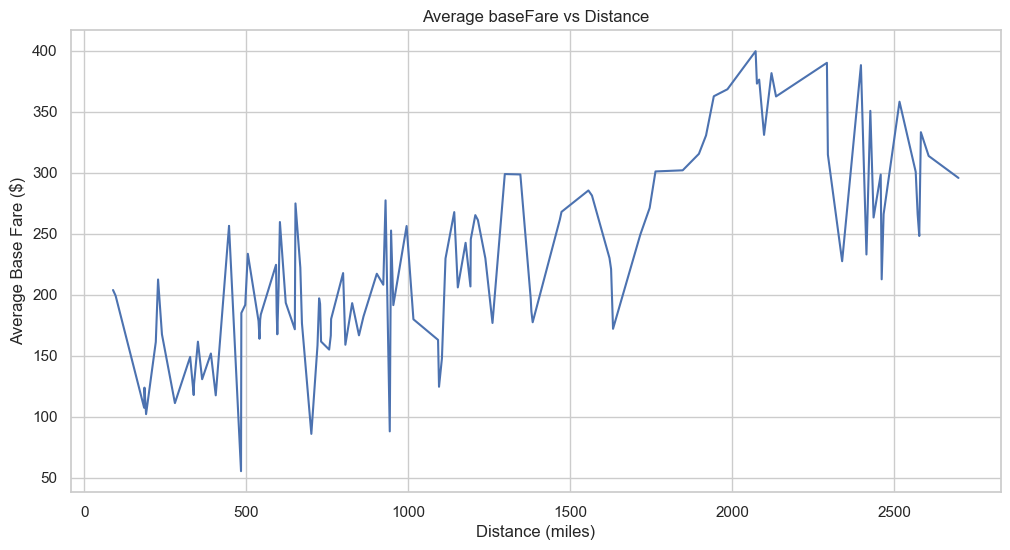

In [12]:
mean_fare_by_distance = cleaned_df.groupby('segmentsDistance')['baseFare'].mean().reset_index()
mean_fare_by_distance.sort_values('segmentsDistance', inplace=True)

# Plot the average baseFare vs distance
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_fare_by_distance, x='segmentsDistance', y='baseFare')

plt.title("Average baseFare vs Distance")
plt.xlabel("Distance (miles)")
plt.ylabel("Average Base Fare ($)")
plt.grid(True)
plt.show()


We will now perform a simple linear regression using the mean_fare_by_distance data, where the dependent variable is baseFare and the independent variable is segmentsDistance.

In [13]:
#Linear Regression class manually
class MyLinearRegression:
    def __init__(self):
        self.coefficients = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.coefficients = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.coefficients


In [14]:
X = mean_fare_by_distance[['segmentsDistance']].values
y = mean_fare_by_distance['baseFare'].values

lin_reg = MyLinearRegression()
lin_reg.fit(X, y)

y_pred = lin_reg.predict(X)

print(f"Intercept: {lin_reg.coefficients[0]}")
print(f"Slope: { lin_reg.coefficients[1:]}")

Intercept: 135.7265883080992
Slope: [0.0757053]


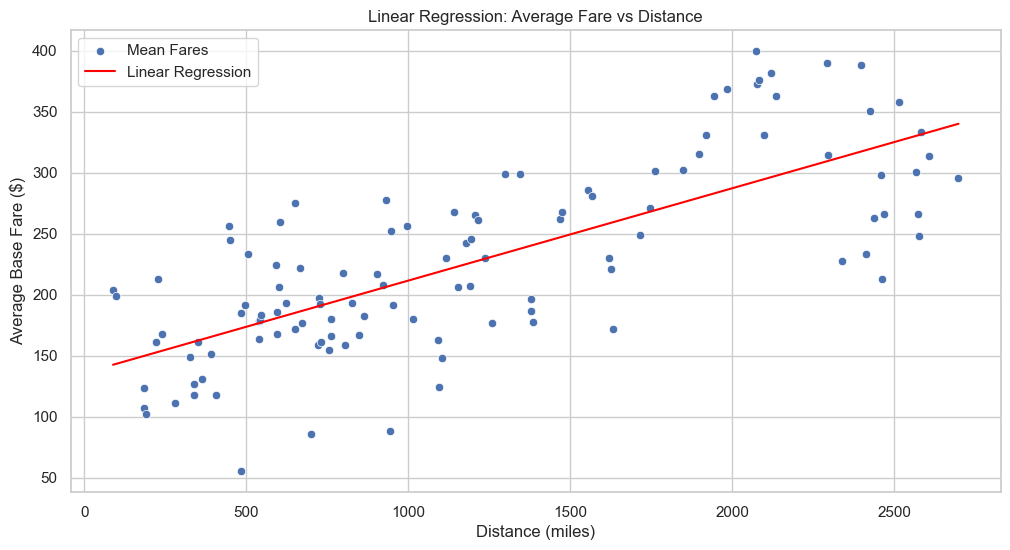

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=mean_fare_by_distance['segmentsDistance'], y=mean_fare_by_distance['baseFare'], label='Mean Fares')
plt.plot(mean_fare_by_distance['segmentsDistance'], y_pred, color='red', label='Linear Regression')
plt.title("Linear Regression: Average Fare vs Distance")
plt.xlabel("Distance (miles)")
plt.ylabel("Average Base Fare ($)")
plt.legend()
plt.grid(True)
plt.show()

We will now compute two common evaluation metrics for regression models:

*   SSE (Sum of Squared Errors): Measures total squared difference between actual and predicted values.
*   MAPE (Mean Absolute Percentage Error): Measures average percent error between predictions and actuals.




In [16]:
sse = np.sum((y - y_pred) ** 2)
print(f"Sum of Squared Errors (SSE): {sse:.4f}")

mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


Sum of Squared Errors (SSE): 290096.8149
Mean Absolute Percentage Error (MAPE): 21.5502%


### Regression Evaluation Results

After fitting a simple linear regression model to predict `baseFare` from rounded `segmentsDistance`, we evaluated the model using the following metrics:

- **Sum of Squared Errors (SSE): 290,096.81**
- **Mean Absolute Percentage Error (MAPE): 21.55%**

These results indicate that while there is a general positive trend between fare and distance (as visualized in the regression plot), the model has a relatively high percentage error. This suggests that **distance alone does not fully explain the variation in fares**, and additional features (e.g., time, airline, seat availability) are likely important factors.

We will explore this in the next section using **multiple linear regression** with a richer set of flight attributes.


## (iii) Predicting Ticket Fares Using Multiple Linear Regression



We begin by selecting only non-stop flights from our cleaned dataset. Then, we extract the 8 numerical features specified in the prompt, along with totalFare as the target variable for regression analysis.

The 8 features are:

* baseFare

* seatsRemaining

* elapsedDays

* segmentsDurationInSeconds

* segmentsDistance

* segmentsDepartureTimeEpochSeconds

* segmentsArrivalTimeEpochSeconds

* travelDuration

We also drop any rows containing missing values in these columns to ensure the regression model is trained on complete data.

In [17]:
features = [
    'baseFare',
    'seatsRemaining',
    'elapsedDays',
    'segmentsDurationInSeconds',
    'segmentsDistance',
    'segmentsDepartureTimeEpochSeconds',
    'segmentsArrivalTimeEpochSeconds',
    'travelDuration'
]

target = 'totalFare'

mlr_df = df[df['isNonStop'] == True][features + [target]]
#Using Isodate for parsing travelDuration
def parse_duration_to_seconds(value):
    try:
        return isodate.parse_duration(value).total_seconds()
    except:
        return None

mlr_df['travelDuration'] = mlr_df['travelDuration'].apply(parse_duration_to_seconds)

columns_to_convert = [
    'segmentsDurationInSeconds',
    'segmentsDistance',
    'segmentsDepartureTimeEpochSeconds',
    'segmentsArrivalTimeEpochSeconds'
]

for col in columns_to_convert:
    mlr_df[col] = pd.to_numeric(mlr_df[col], errors='coerce')

print("Before dropna:", len(mlr_df))
mlr_df.dropna(inplace=True)
print("After dropna:", len(mlr_df))

print(mlr_df.dtypes)


Before dropna: 996418
After dropna: 996418
baseFare                             float64
seatsRemaining                         int64
elapsedDays                            int64
segmentsDurationInSeconds              int64
segmentsDistance                       int64
segmentsDepartureTimeEpochSeconds      int64
segmentsArrivalTimeEpochSeconds        int64
travelDuration                       float64
totalFare                            float64
dtype: object


In [18]:
def my_pearson_correlation(df, target_col):
    correlations = {}
    y = df[target_col].values
    y_mean = y.mean()
    y_std = y.std()

    for col in df.columns:
        if col == target_col:
            continue

        x = df[col].values
        x_mean = x.mean()
        x_std = x.std()

        if x_std == 0 or y_std == 0:
            corr = 0.0
        else:
            numerator = np.sum((x - x_mean) * (y - y_mean))
            denominator = len(x) * x_std * y_std
            corr = numerator / denominator

        correlations[col] = corr

    corr_series = pd.Series(correlations)
    return corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)


In [19]:
# Compute Pearson correlation between features and totalFare
correlations = my_pearson_correlation(mlr_df, target_col='totalFare')
print("Pearson correlation with totalFare:")
print(correlations)


Pearson correlation with totalFare:
baseFare                             0.999996
segmentsDistance                     0.493304
travelDuration                       0.476867
segmentsDurationInSeconds            0.476867
segmentsDepartureTimeEpochSeconds   -0.186296
segmentsArrivalTimeEpochSeconds     -0.185740
seatsRemaining                      -0.096923
elapsedDays                          0.096695
dtype: float64


### **Pearson Correlation Analysis**

We computed the Pearson correlation between each of the 8 numerical features and `totalFare`. This helps identify which features are most linearly associated with the target variable, and serves as the basis for selecting a reduced subset for regression.

Here are the results:

| Feature                             | Correlation with `totalFare` |
|-------------------------------------|-------------------------------|
| `baseFare`                          | **0.999996**                  |
| `segmentsDistance`                 | 0.493                         |
| `travelDuration`                   | 0.477                         |
| `segmentsDurationInSeconds`       | 0.477                         |
| `segmentsDepartureTimeEpochSeconds`| -0.186                        |
| `segmentsArrivalTimeEpochSeconds`  | -0.186                        |
| `seatsRemaining`                  | -0.097                        |
| `elapsedDays`                     | 0.097                         |

### 🔍 Observations:
- `baseFare` is almost perfectly correlated with `totalFare` (**0.999996**), which is expected since it forms the majority of the final price.
- `segmentsDistance`, `travelDuration`, and `segmentsDurationInSeconds` show **moderate positive correlations** (~0.47–0.49).
- Epoch times and seat availability show **weaker correlations** (~0.1–0.18), indicating weaker direct influence.
  
Based on this analysis, we will select the following **reduced subset** of features for modeling:
- `baseFare`
- `segmentsDistance`
- `travelDuration`

These were chosen for their relatively strong correlations and diverse representation of pricing factors (fare base, flight length, and time).


In [20]:
#Cosine Similartiy from scratch
def my_cosine_similarity(X):
    norms = np.linalg.norm(X, axis=0)
    X_normalized = X / norms

    similarity_matrix = X_normalized.T @ X_normalized
    return similarity_matrix

In [21]:
selected_features = ['baseFare', 'segmentsDistance', 'travelDuration']
X_selected = mlr_df[selected_features].values

X_standardized = (X_selected - X_selected.mean(axis=0)) / X_selected.std(axis=0)

similarity_matrix = my_cosine_similarity(X_standardized)

import pandas as pd
similarity_df = pd.DataFrame(similarity_matrix, index=selected_features, columns=selected_features)

print("Cosine Similarity Matrix:")
print(similarity_df)


Cosine Similarity Matrix:
                  baseFare  segmentsDistance  travelDuration
baseFare          1.000000          0.492962        0.476497
segmentsDistance  0.492962          1.000000        0.986230
travelDuration    0.476497          0.986230        1.000000


### **Cosine Similarity Filtering**

To identify and eliminate redundant features, we computed the **cosine similarity matrix** for the selected subset of features:

- `baseFare`
- `segmentsDistance`
- `travelDuration`

#### 🔎 Cosine Similarity Matrix:

| Feature Pair                      | Cosine Similarity |
|----------------------------------|-------------------|
| `segmentsDistance` & `travelDuration` | **0.986** (very high) |
| `baseFare` & `segmentsDistance`       | 0.493 |
| `baseFare` & `travelDuration`         | 0.476 |

#### Observation:
The pair `segmentsDistance` and `travelDuration` have a **very high similarity (0.986)**, indicating strong redundancy. Including both in a linear model may introduce multicollinearity and reduce model interpretability.

We choose to **retain `segmentsDistance`** and **drop `travelDuration`** for the reduced model because:
- It is more interpretable and directly linked to fare pricing.
- It captures the spatial dimension of the flight without the variability introduced by time-based delays or routing.

#### Final Selected Feature Subset:
- `baseFare`
- `segmentsDistance`


In [22]:
def my_train_test_split(X, y, test_size=0.3, random_state=None):
    np.random.seed(random_state)

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split_idx = int(len(X) * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


In [23]:
X_full = mlr_df[features].values
y_full = mlr_df['totalFare'].values
X_train_full, X_test_full, y_train_full, y_test_full = my_train_test_split(X_full, y_full, test_size=0.3, random_state=66701)

# Train full model
model_full = MyLinearRegression()
model_full.fit(X_train_full, y_train_full)

y_train_pred_full = model_full.predict(X_train_full)
y_test_pred_full = model_full.predict(X_test_full)

sse_train_full = np.sum((y_train_full - y_train_pred_full) ** 2)
sse_test_full = np.sum((y_test_full - y_test_pred_full) ** 2)

print(f"SSE (Train - Full Model): {sse_train_full:.2f}")
print(f"SSE (Test - Full Model): {sse_test_full:.2f}")

SSE (Train - Full Model): 137636.30
SSE (Test - Full Model): 59889.67


In [24]:
reduced_features = ['baseFare', 'segmentsDistance']

X_reduced = mlr_df[reduced_features].values
y_reduced = mlr_df['totalFare'].values
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = my_train_test_split(X_reduced, y_reduced, test_size=0.3, random_state=66701)

# Train reduced model
model_reduced = MyLinearRegression()
model_reduced.fit(X_train_reduced, y_train_reduced)

y_train_pred_reduced = model_reduced.predict(X_train_reduced)
y_test_pred_reduced = model_reduced.predict(X_test_reduced)

sse_train_reduced = np.sum((y_train_reduced - y_train_pred_reduced) ** 2)
sse_test_reduced = np.sum((y_test_reduced - y_test_pred_reduced) ** 2)

print(f"SSE (Train - Reduced Model): {sse_train_reduced:.2f}")
print(f"SSE (Test - Reduced Model): {sse_test_reduced:.2f}")


SSE (Train - Reduced Model): 136692.09
SSE (Test - Reduced Model): 59477.52


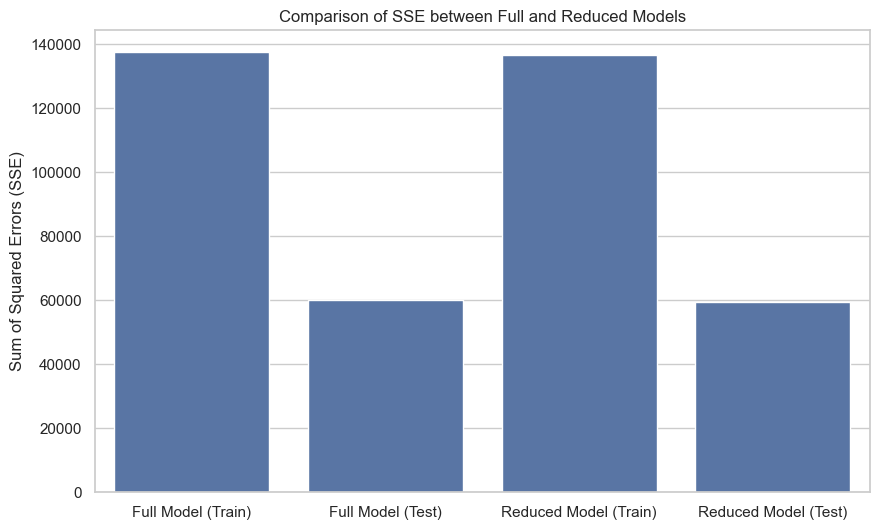

In [25]:
labels = ['Full Model (Train)', 'Full Model (Test)', 'Reduced Model (Train)', 'Reduced Model (Test)']
sse_values = [sse_train_full, sse_test_full, sse_train_reduced, sse_test_reduced]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=sse_values)
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Comparison of SSE between Full and Reduced Models')
plt.show()

### Final Evaluation

- The **Full Model** slightly outperforms the **Reduced Model** in both training and test SSE.
- However, the **difference is very small**:
  - Train SSE: only ~800 difference
  - Test SSE: only ~300 difference

### Conclusion

The **Reduced Model (2 features: `baseFare`, `segmentsDistance`)** performs **nearly as well** as the Full Model with all 8 features. This suggests that these two features alone capture most of the variance in ticket pricing.

Using the reduced model offers:
- Simpler interpretation
- Lower risk of overfitting
- Better generalizability with fewer inputs

Thus, for practical applications, the reduced model is a strong candidate.
